# Re-implementation of PSeudoEdgeNet and "Where are the blobs"

## Dataset

Two H&E image datasets were used to test those two algorithms. One is MoNuSeg while the other is TNBC. Here we display three images as examples for each dataset

### MoNuSeg

Introduction from the official website()

<blockquote>Nuclear segmentation in digital microscopic tissue images could enable the extraction of high-quality features for nuclear morphometrics and other analysis in computational pathology. Techniques that accurately segment nuclei in diverse tissue images spanning a range of patients, organs, and disease states, can significantly contribute to the development of clinical and medical research software. Once accurately segmented, nuclear morphometric and appearance features such as nuclei density, nucleus-to-cytoplasm ratio, average size, and pleomorphism can be used to assess not only cancer grades but also for predicting treatment effectiveness. Identifying different types of nuclei based on their segmentation can also yield information about gland shapes, which, for example, is important for cancer grading.

This challenge will showcase the best nuclei segmentation techniques that will work on a diverse set of H&E stained histology images obtained from different hospitals spanning multiple patients and organs. This will enable the training and testing of readily usable  (or generalized) nuclear segmentation softwares.

MoNuSeg is an official satellite event of MICCAI 2018.</blockquote>

link: https://monuseg.grand-challenge.org/

In [1]:
import matplotlib.pyplot as plt
from albumentations import Flip, ShiftScaleRotate, RandomRotate90, RandomCrop
from src.datasets import HEDataset,ConsepDataset

MoNuSegdisplay_set = ConsepDataset(data_dir = './CoNSeP', option = 'Train')
MoNu_0 = MoNuSegdisplay_set[0]
MoNu_1 = MoNuSegdisplay_set[1]
MoNu_2 = MoNuSegdisplay_set[2]

fig,axes = plt.subplots(1,3, figsize=(30,10))

axes[0].imshow(MoNu_0["images"].numpy().transpose(1,2,0))
axes[1].imshow(MoNu_1["images"].numpy().transpose(1,2,0))
axes[2].imshow(MoNu_2["images"].numpy().transpose(1,2,0))

# axes[0].imshow(MoNu_0["obj"].numpy(),cmap='jet')
# axes[1].imshow(MoNu_1["obj"].numpy(),cmap='jet')
# axes[2].imshow(MoNu_2["obj"].numpy(),cmap='jet')

# axes[0].imshow(test_0["points"]+test_0["bkg"])
# axes[1].imshow(test_0["points"])
# axes[2].imshow(test_0["gt"])

/home/wzy/.conda/envs/general/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wzy/.conda/envs/general/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module '_watershed_cy' does not match runtime version 3.7
  return f(*args, **kwds)


In [ ]:
MoNuSegdisplay_set.data_dir

'./CoNSeP'

### TNBC

Abstract from data source
<blockquote>We make our dataset publicly avaiable. It consists of 50 H&E stained histopathology annotated images at the nuclei level. This dataset is ideal for those who want an exhaustive annotation of H&E breast cancer patient from a Tripple Negative Breast Cancer cohort.</blockquote>

ref: Naylor Peter; Laé Marick; Reyal Fabien; Walter Thomas; , "Segmentation of Nuclei in Histopathology Images by deep regression of the distance map", IEEE Dataport, 2018. [Online]. Available: http://dx.doi.org/10.21227/H26X0H. Accessed: Jul. 23, 2020.

link: https://ieee-dataport.org/documents/segmentation-nuclei-histopathology-images-deep-regression-distance-map

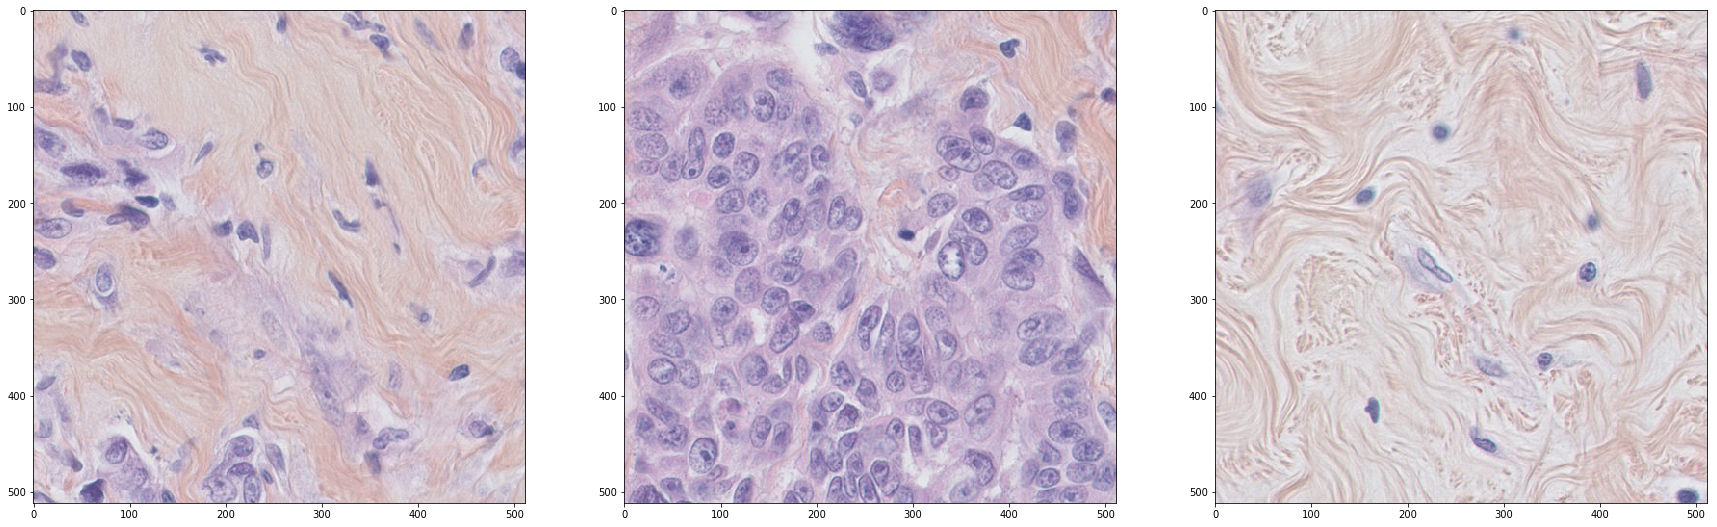

In [ ]:
from src.datasets import HEDataset
import matplotlib.pyplot as plt
from albumentations import Flip, ShiftScaleRotate, RandomRotate90, RandomCrop
%matplotlib inline

TNBCdisplay_set = HEDataset('./TNBC/dataset.hdf5', 
                 index = [0,1,2])
TNBC_0 = TNBCdisplay_set[0]
TNBC_1 = TNBCdisplay_set[1]
TNBC_2 = TNBCdisplay_set[2]

fig,axes = plt.subplots(1,3, figsize=(30,10))

axes[0].imshow(TNBC_0["images"].numpy().transpose(1,2,0))
axes[1].imshow(TNBC_1["images"].numpy().transpose(1,2,0))
axes[2].imshow(TNBC_2["images"].numpy().transpose(1,2,0))

# axes[0].imshow(test_0["points"]+test_0["bkg"])
# axes[1].imshow(test_0["points"])
# axes[2].imshow(test_0["gt"])

## Inputs and targets of the algorithms

For each image, the point label, background label(generated by distance transformation) and the ground truth(which is only used when evaluate the model in the final stage). Here is what it's like.

In [ ]:
help(A.Compose)

Help on class Compose in module albumentations.core.composition:

class Compose(BaseCompose)
 |  Compose transforms and handle all transformations regrading bounding boxes
 |  
 |  Args:
 |      transforms (list): list of transformations to compose.
 |      bbox_params (BboxParams): Parameters for bounding boxes transforms
 |      keypoint_params (KeypointParams): Parameters for keypoints transforms
 |      additional_targets (dict): Dict with keys - new target name, values - old target name. ex: {'image2': 'image'}
 |      p (float): probability of applying all list of transforms. Default: 1.0.
 |  
 |  Method resolution order:
 |      Compose
 |      BaseCompose
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, force_apply=False, **data)
 |      Call self as a function.
 |  
 |  __init__(self, transforms, bbox_params=None, keypoint_params=None, additional_targets=None, p=1.0)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  

In [ ]:
import albumentations as A
from src.datasets import HEDataset
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(236796)
transform = A.Compose([A.RandomCrop(256,256), 
                       A.Flip(), 
                       A.Affine(), 
                       A.Rotate(), 
                       A.HueSaturationValue(), 
                       A.GaussianBlur(), 
                       A.GaussNoise()], 
                      keypoint_params = A.KeypointParams(format='yx'), 
                      additional_targets = {'mask0':'mask', 
                                            'mask1':'mask',
                                            'mask2':'mask',
                                            })
# 调用ConsepDataset类构建了一个数据集
# MoNuSegdisplay_set = HEDataset(data_dir = './MoNuSegTrainingData',transform = transform, option = 'Train')
MoNuSegdisplay_set = ConsepDataset(data_dir = './CoNSeP',transform = transform, option = 'Train')

65


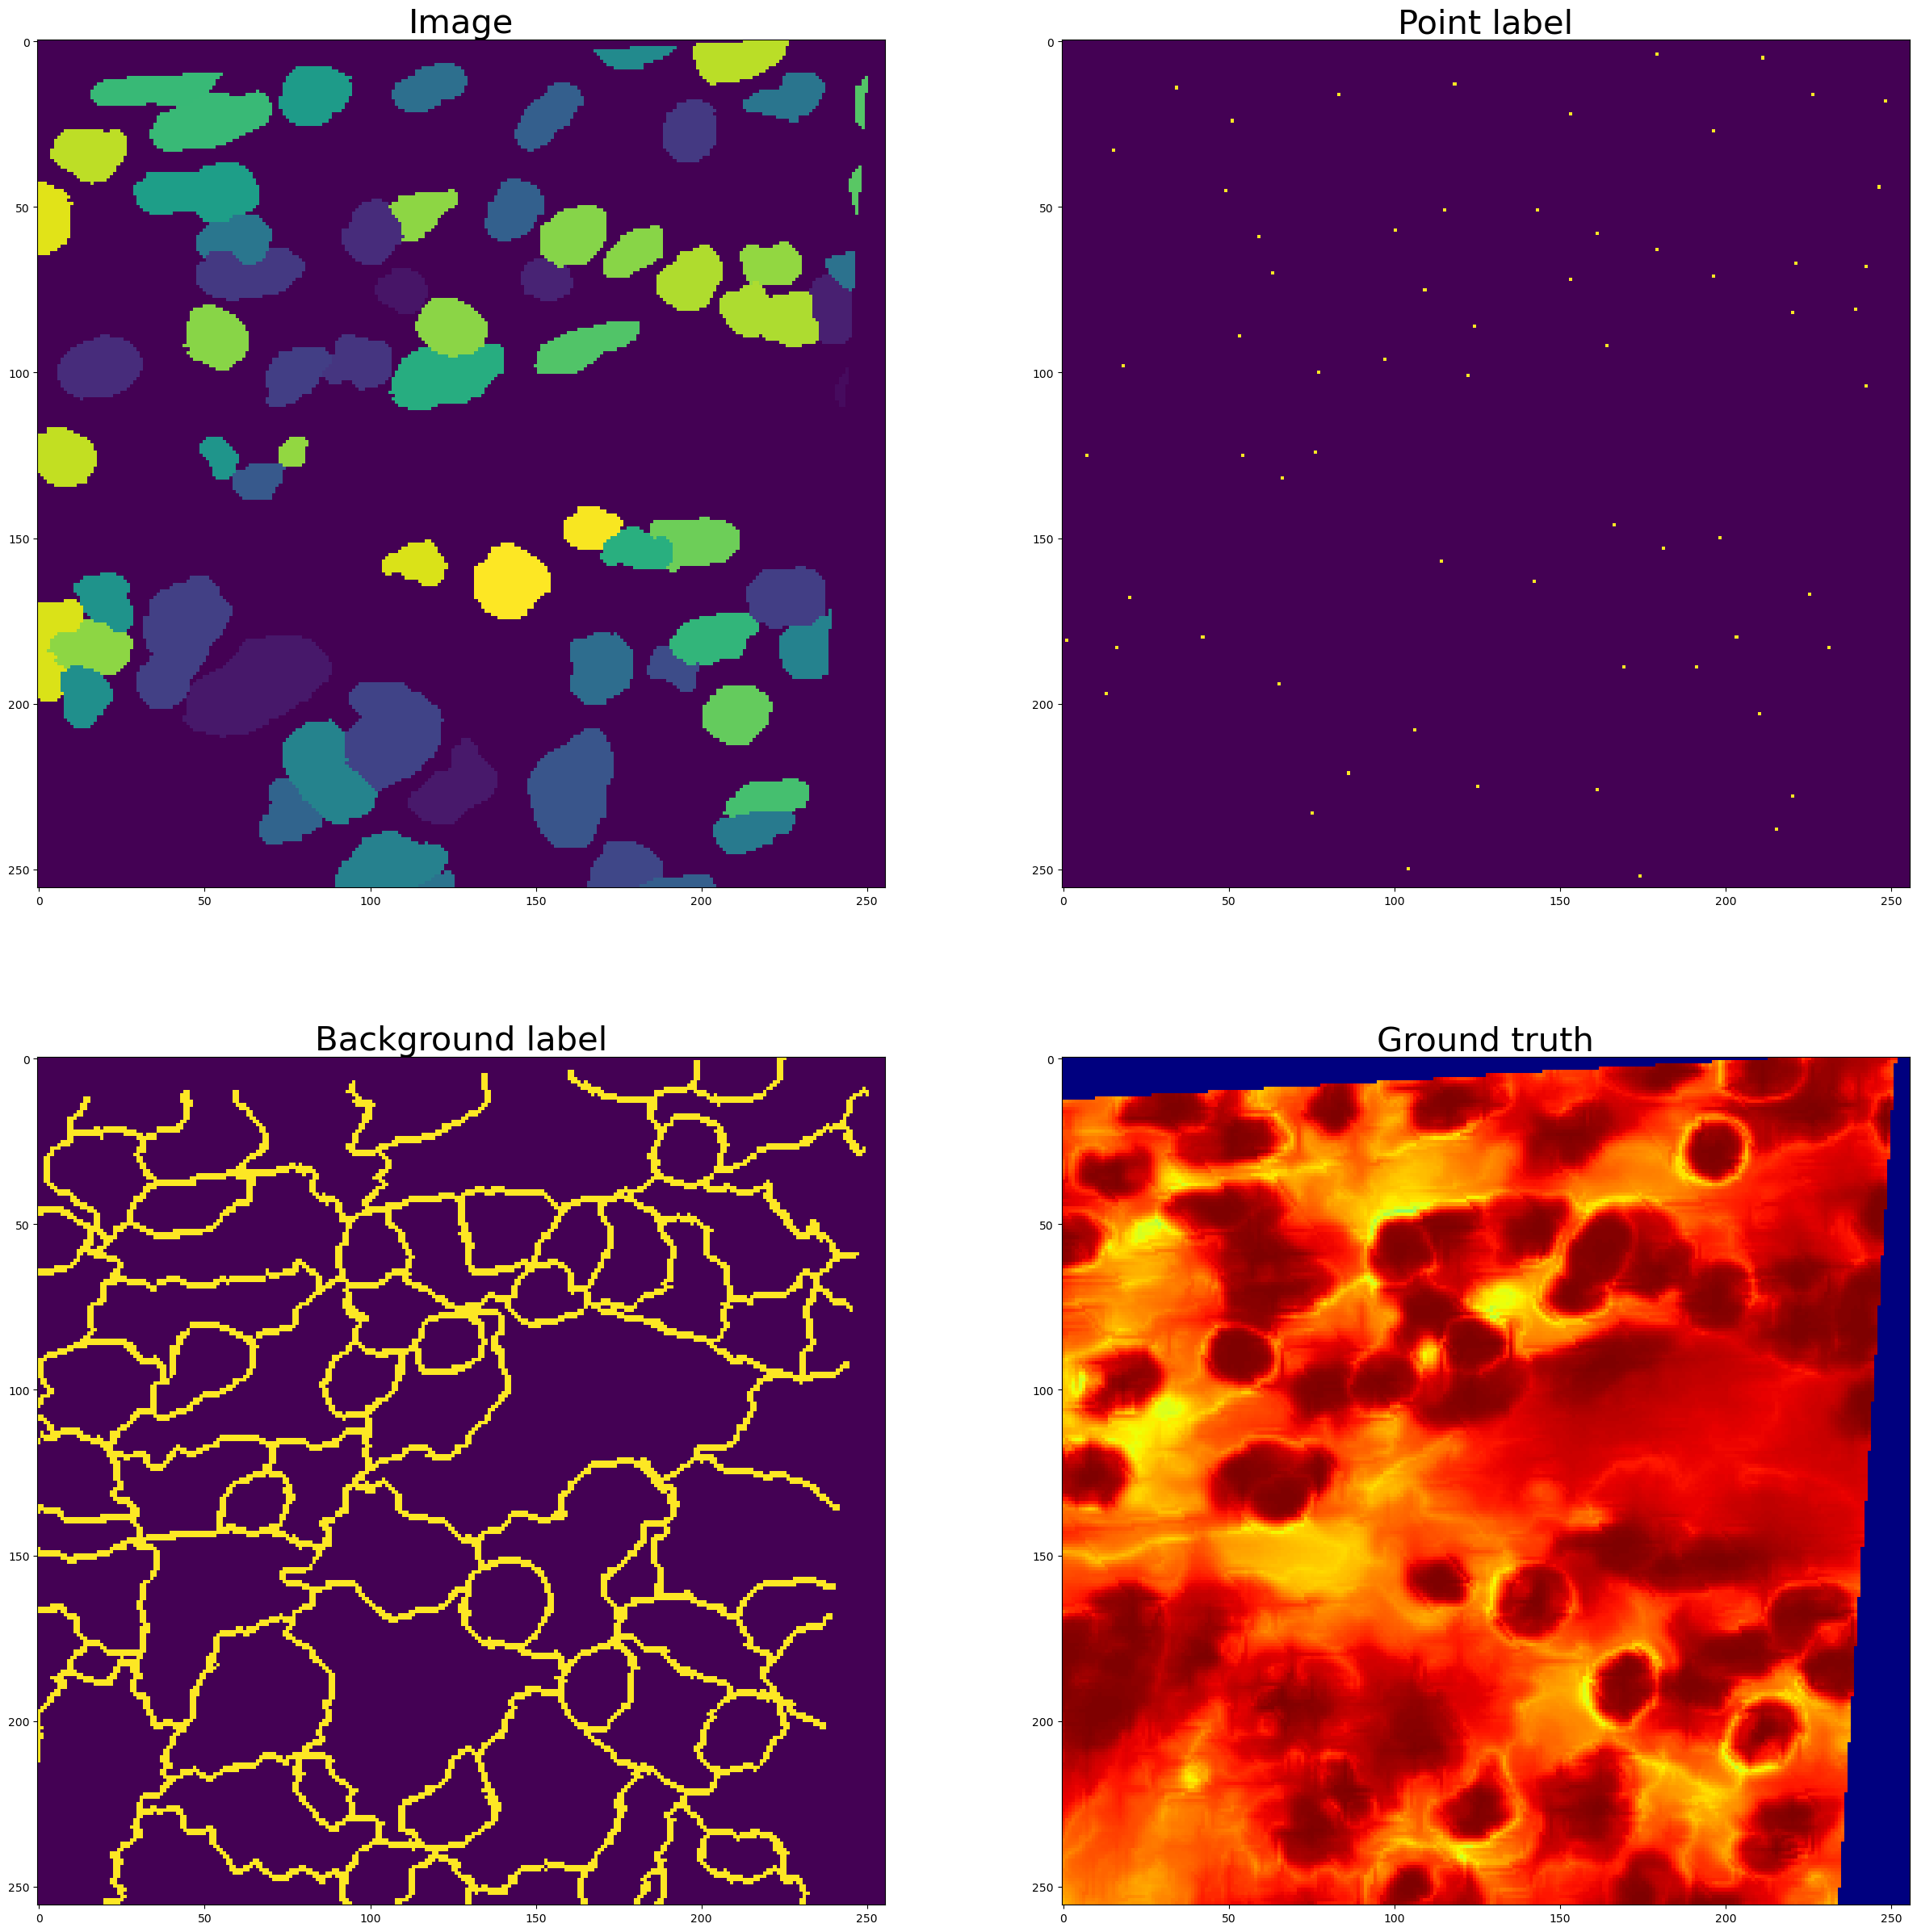

In [ ]:
MoNu_0 = MoNuSegdisplay_set[0]

fig1,axes1 = plt.subplots(2,2,figsize = (30,30))
axes1[0,0].imshow(MoNu_0["gt"].numpy())         

axes1[0,1].imshow(MoNu_0["points"])
axes1[1,0].imshow(MoNu_0["bkg"])
axes1[1,1].imshow(MoNu_0["obj"], cmap='jet')
_ = axes1[0,0].set_title('Image',fontsize = 30)
_ = axes1[0,1].set_title('Point label',fontsize = 30)
_ = axes1[1,0].set_title('Background label',fontsize = 30)
_ = axes1[1,1].set_title('Ground truth',fontsize = 30)
print(MoNu_0["counts"])

## Train and validation

For each dataset, the images were splitted into 10 folds. We will perform a 10-fold corss-validation. The validation result and the checkpoints will be saved in a folder named <i>Result</i> inside the fold folder.

In [ ]:
from haven import haven_utils as hu
ponet_exp_dict ={
    "batch_size": 1,
    "lr": 0.001,
    "max_epoch": 20,
    "model": {
        "name": "ponet"
        
    },
    "optimizer": "adam",
    "patch_size":256,
    "obj":None,   
    "bkg":None,
    "n_classes":2
}

hu.save_json("exp_config_ponet.json", ponet_exp_dict)

/home/wzy/.conda/envs/general/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module '_watershed_cy' does not match runtime version 3.7
  return f(*args, **kwds)


In [ ]:
import albumentations as A
import random
data_transform = A.Compose([A.Flip(p=0.3),
                            A.Affine(p=0.3),
                            A.Rotate(p=0.3),
                            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
                            A.GaussianBlur(3, p=0.3),
                            A.GaussNoise(30, p=0.3)],
                            keypoint_params=A.KeypointParams(format='yx'),
                            additional_targets={'mask0': 'mask',
                                                'mask1': 'mask',
                                                'mask2': 'mask'})

# random.seed(20201009)
random_seed = random.randint(0, 20201009)

/home/wzy/.conda/envs/general/lib/python3.7/site-packages/albumentations/augmentations/blur/transforms.py:185: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


In [ ]:
import glob,os
from trainval import trainval
from haven import haven_utils as hu
import matplotlib.pyplot as plt
%matplotlib inline

# Define the dataset you want to train on, you can type 'TNBC' or 'MoNuSegTrainingData'
datadir = './CoNSeP/' 

# the exp_dict is the configuration of the model which has already been saved. 
# It consists of the initial learning rate, max epoch, model name and optimizer
# The saved one looks like this
# {
#     "batch_size": 1,
#     "lr": 0.001,
#     "max_epoch": 20,
#     "model": {
#         "name": "penet"
#     },
#     "optimizer": "adam"
# }
exp_dict = hu.load_json('Experiment_Exp/exp_config_mynet_1.json')
exp_dict["batch_size"] = 64
exp_dict["max_epoch"] = 100
# folddir_10 = glob.glob(os.path.join(datadir, '*_fold'))

# for folddir in folddir_10:
#     savedir_base = os.path.join(folddir,'Result')
#     os.makedirs(savedir_base,exist_ok=True)
savedir_base = "./Result"
os.makedirs(savedir_base,exist_ok=True)
trainval(exp_dict, savedir_base, datadir, reset=False, num_workers=25)

Experiment saved in ./Result/f437d8627fba98be993e18825860eaa3


/home/wzy/.conda/envs/general/lib/python3.7/site-packages/albumentations/augmentations/blur/transforms.py:185: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "
/home/wzy/.conda/envs/general/lib/python3.7/site-packages/torch/cuda/__init__.py:145: UserWarning: 
NVIDIA GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


Starting experiment at epoch 0


  0%|          | 0/3375 [00:00<?, ?it/s]

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
import glob,os
from trainval import trainval
from haven import haven_utils as hu
import matplotlib.pyplot as plt
%matplotlib inline

# Define the dataset you want to train on, you can type 'TNBC' or 'MoNuSegTrainingData'
datadir = './CoNSeP/' 

# the exp_dict is the configuration of the model which has already been saved. 
# It consists of the initial learning rate, max epoch, model name and optimizer
# The saved one looks like this
# {
#     "batch_size": 1,
#     "lr": 0.001,
#     "max_epoch": 20,
#     "model": {
#         "name": "penet"
#     },
#     "optimizer": "adam"
# }
exp_dict = hu.load_json('exp_config_ponet.json')
exp_dict["batch_size"] = 64
exp_dict["max_epoch"] = 100
# folddir_10 = glob.glob(os.path.join(datadir, '*_fold'))

# for folddir in folddir_10:
#     savedir_base = os.path.join(folddir,'Result')
#     os.makedirs(savedir_base,exist_ok=True)
savedir_base = "./Result"
os.makedirs(savedir_base,exist_ok=True)
trainval(exp_dict, savedir_base, datadir, reset=False, num_workers=25)

Experiment saved in ./Result/ponet
Let's use 2 GPUs!



  0%|          | 0/211 [00:00<?, ?it/s]

Starting experiment at epoch 0


Validating. MAE: 0.5012: 100%|██████████| 7/7 [00:11<00:00,  1.62s/it]



    epoch  train_loss   val_mae  val_score
0      0    2.589484  0.501212   0.501212 

Checkpoint Saved: ./Result/ponet



  0%|          | 0/211 [00:00<?, ?it/s]

Saved Best: ./Result/ponet


Validating. MAE: 0.4177: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]



    epoch  train_loss   val_mae  val_score
0      0    2.589484  0.501212   0.501212
1      1    1.987646  0.417669   0.417669 




  0%|          | 0/211 [00:00<?, ?it/s]

Checkpoint Saved: ./Result/ponet


Validating. MAE: 0.4326: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]



    epoch  train_loss   val_mae  val_score
0      0    2.589484  0.501212   0.501212
1      1    1.987646  0.417669   0.417669
2      2    1.765529  0.432571   0.432571 




  0%|          | 0/211 [00:00<?, ?it/s]

Checkpoint Saved: ./Result/ponet


Validating. MAE: 0.4326: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]



    epoch  train_loss   val_mae  val_score
0      0    2.589484  0.501212   0.501212
1      1    1.987646  0.417669   0.417669
2      2    1.765529  0.432571   0.432571
3      3    1.570274  0.432617   0.432617 




  0%|          | 0/211 [00:00<?, ?it/s]

Checkpoint Saved: ./Result/ponet


Validating. MAE: 0.3542: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]



    epoch  train_loss   val_mae  val_score
0      0    2.589484  0.501212   0.501212
1      1    1.987646  0.417669   0.417669
2      2    1.765529  0.432571   0.432571
3      3    1.570274  0.432617   0.432617
4      4    1.484055  0.354177   0.354177 




  0%|          | 0/211 [00:00<?, ?it/s]

Checkpoint Saved: ./Result/ponet


Validating. MAE: 0.4562: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]



    epoch  train_loss   val_mae  val_score
1      1    1.987646  0.417669   0.417669
2      2    1.765529  0.432571   0.432571
3      3    1.570274  0.432617   0.432617
4      4    1.484055  0.354177   0.354177
5      5    1.376505  0.456218   0.456218 




  0%|          | 0/211 [00:00<?, ?it/s]

Checkpoint Saved: ./Result/ponet


Validating. MAE: 0.4172: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]



    epoch  train_loss   val_mae  val_score
2      2    1.765529  0.432571   0.432571
3      3    1.570274  0.432617   0.432617
4      4    1.484055  0.354177   0.354177
5      5    1.376505  0.456218   0.456218
6      6    1.332121  0.417190   0.417190 




  0%|          | 0/211 [00:00<?, ?it/s]

Checkpoint Saved: ./Result/ponet


Validating. MAE: 0.5236: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]



    epoch  train_loss   val_mae  val_score
3      3    1.570274  0.432617   0.432617
4      4    1.484055  0.354177   0.354177
5      5    1.376505  0.456218   0.456218
6      6    1.332121  0.417190   0.417190
7      7    1.259955  0.523616   0.523616 

Checkpoint Saved: ./Result/ponet



  0%|          | 0/211 [00:00<?, ?it/s]

Saved Best: ./Result/ponet


Validating. MAE: 0.4914: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]



    epoch  train_loss   val_mae  val_score
4      4    1.484055  0.354177   0.354177
5      5    1.376505  0.456218   0.456218
6      6    1.332121  0.417190   0.417190
7      7    1.259955  0.523616   0.523616
8      8    1.230194  0.491424   0.491424 




  0%|          | 0/211 [00:00<?, ?it/s]

Checkpoint Saved: ./Result/ponet


Validating. MAE: 0.4763: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]



    epoch  train_loss   val_mae  val_score
5      5    1.376505  0.456218   0.456218
6      6    1.332121  0.417190   0.417190
7      7    1.259955  0.523616   0.523616
8      8    1.230194  0.491424   0.491424
9      9    1.227168  0.476279   0.476279 




  0%|          | 0/211 [00:00<?, ?it/s]

Checkpoint Saved: ./Result/ponet


Validating. MAE: 0.4830: 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]



     epoch  train_loss   val_mae  val_score
6       6    1.332121  0.417190   0.417190
7       7    1.259955  0.523616   0.523616
8       8    1.230194  0.491424   0.491424
9       9    1.227168  0.476279   0.476279
10     10    1.176264  0.482978   0.482978 




  0%|          | 0/211 [00:00<?, ?it/s]

Checkpoint Saved: ./Result/ponet


Validating. MAE: 0.4685: 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]



     epoch  train_loss   val_mae  val_score
7       7    1.259955  0.523616   0.523616
8       8    1.230194  0.491424   0.491424
9       9    1.227168  0.476279   0.476279
10     10    1.176264  0.482978   0.482978
11     11    1.132242  0.468495   0.468495 




  0%|          | 0/211 [00:00<?, ?it/s]

Checkpoint Saved: ./Result/ponet


KeyboardInterrupt: 

In [ ]:
from src import models
from src.datasets import HEDataset
from trainval import loadsplittedfolds
from haven import haven_utils as hu
import albumentations as A
import os,glob
import torch

datadir = './CoNSeP/' 
# folddir_10 = glob.glob(os.path.join(datadir, '*_fold'))

# folddir = folddir_10[0]

exp_dict = hu.load_json('exp_config_ponet.json')

test_transform = A.Compose([A.Resize(1024,1024)], 
                          keypoint_params = A.KeypointParams(format='xy'), 
                          additional_targets = {'mask0':'mask', 
                                                'mask1':'mask'})

# tr_idx, val_idx, ts_idx = loadsplittedfolds(folddir)
test_set = test_set = HEDataset(data_dir = datadir, 
                                transform = test_transform,
                                option = "Test")



model = models.get_model(exp_dict['model'],exp_dict = exp_dict,train_set = test_set)
model.load_state_dict(torch.load('Result/ponet/model_best.pth'))

Let's use 2 GPUs!


In [ ]:
index = 4
test_im = test_set[index]['images'][None]
model.eval()
test_logit = model.model_base(test_im.to(model.device))

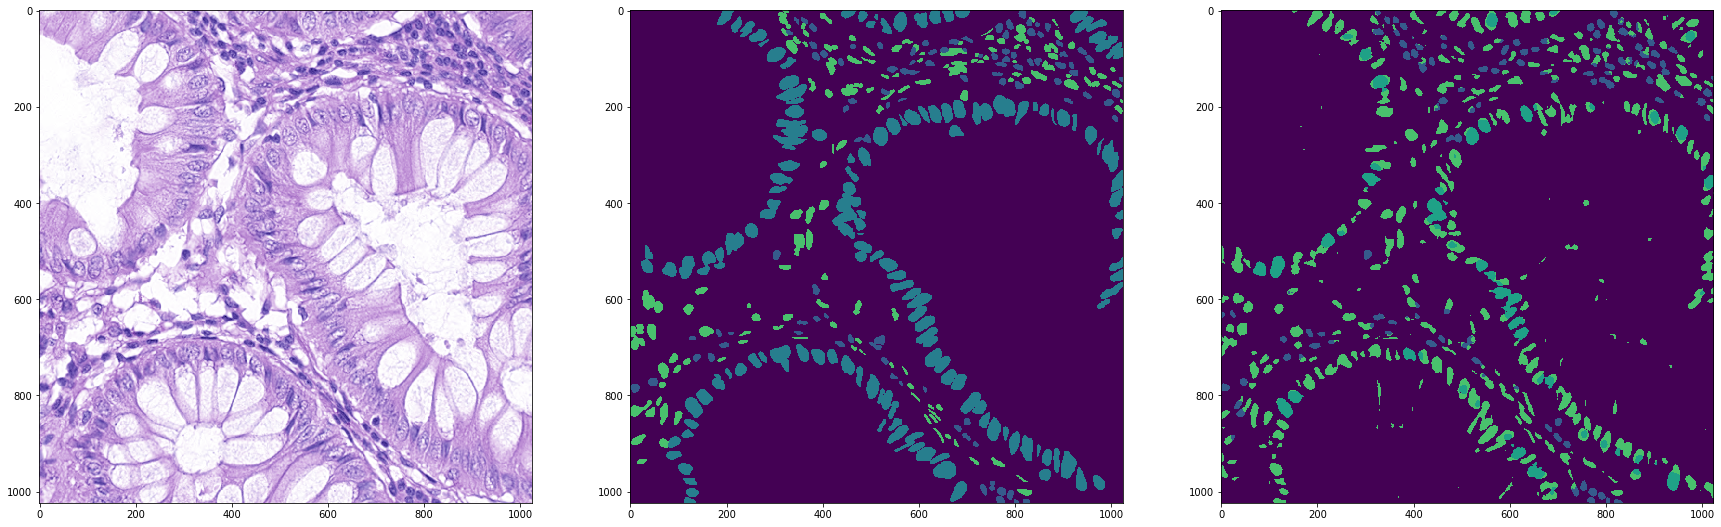

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

test_prob = test_logit.sigmoid()
test_seg = torch.argmax(test_prob, dim = 1)
fig, axes = plt.subplots(1,3, figsize = (30,10))
axes[0].imshow(test_im[0].detach().cpu().numpy().transpose(1,2,0))
axes[1].imshow(test_set[index]['gt'],vmax = 7, vmin = 0)
axes[2].imshow(test_seg[0].detach().cpu().numpy(),vmax = 7, vmin = 0)

Text(0.5, 1.0, 'Output of attention module h(I)')

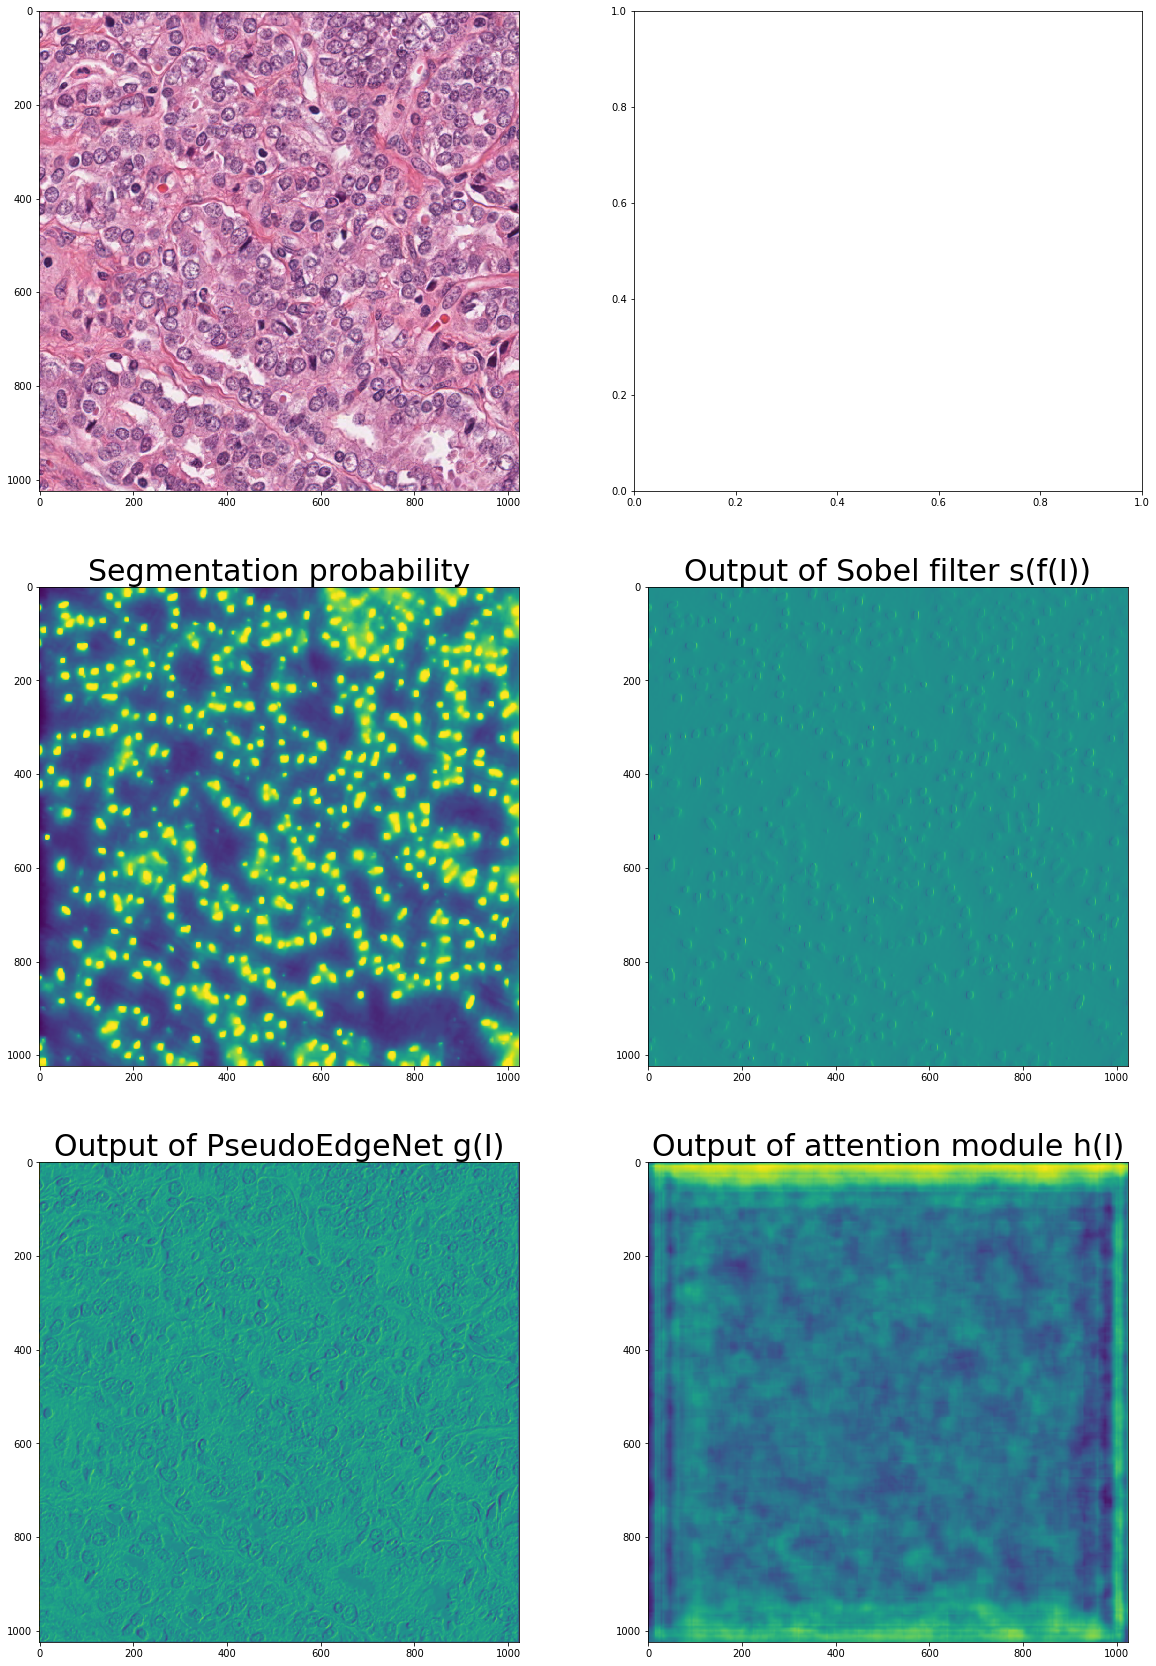

In [ ]:
test_im = test_set[0]['images'][None]
model.eval()
test_logit = model.model_base(test_im)
test_edge = model.Sobel(test_logit).detach().numpy()
test_logit = test_logit.detach().numpy()
test_gI = model.g(test_im).detach().numpy()
test_hI = model.h(test_im).detach().numpy()

fig,axes = plt.subplots(3,2,figsize = (20,30))
axes[0,0].imshow(test_im.detach().numpy()[0].transpose(1,2,0))
axes[1,0].imshow(test_logit[0,0])
axes[1,0].set_title('Segmentation probability',fontsize=30)
axes[1,1].imshow(test_edge[0,0])
axes[1,1].set_title('Output of Sobel filter s(f(I))',fontsize=30)
axes[2,0].imshow(test_gI[0,0])
axes[2,0].set_title('Output of PseudoEdgeNet g(I)',fontsize=30)
axes[2,1].imshow(test_hI[0,0])
axes[2,1].set_title('Output of attention module h(I)',fontsize=30)